In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
from pprint import pprint
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [152]:
TRAIN_DATA_PATH = "../dataset/train"
train_data_dir = Path(TRAIN_DATA_PATH)

TEST_DATA_PATH = "../dataset/test"
test_data_dir = Path(TEST_DATA_PATH)

DEV_DATA_PATH = "../dataset/dev"
dev_data_dir = Path(DEV_DATA_PATH)

train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=32,
    seed=0,
    output_sequence_length=16000,
)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=32,
    seed=0,
    output_sequence_length=16000,
)

dev_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=dev_data_dir,
    batch_size=32,
    seed=0,
    output_sequence_length=16000,
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)
train_ds.element_spec

Found 1403 files belonging to 6 classes.
Found 181 files belonging to 6 classes.
Found 181 files belonging to 6 classes.

label names: ['avance' 'droite' 'gauche' 'recule' 'start' 'stop']


(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [153]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
dev_ds = dev_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [154]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)



(32, 16000)
(32,)


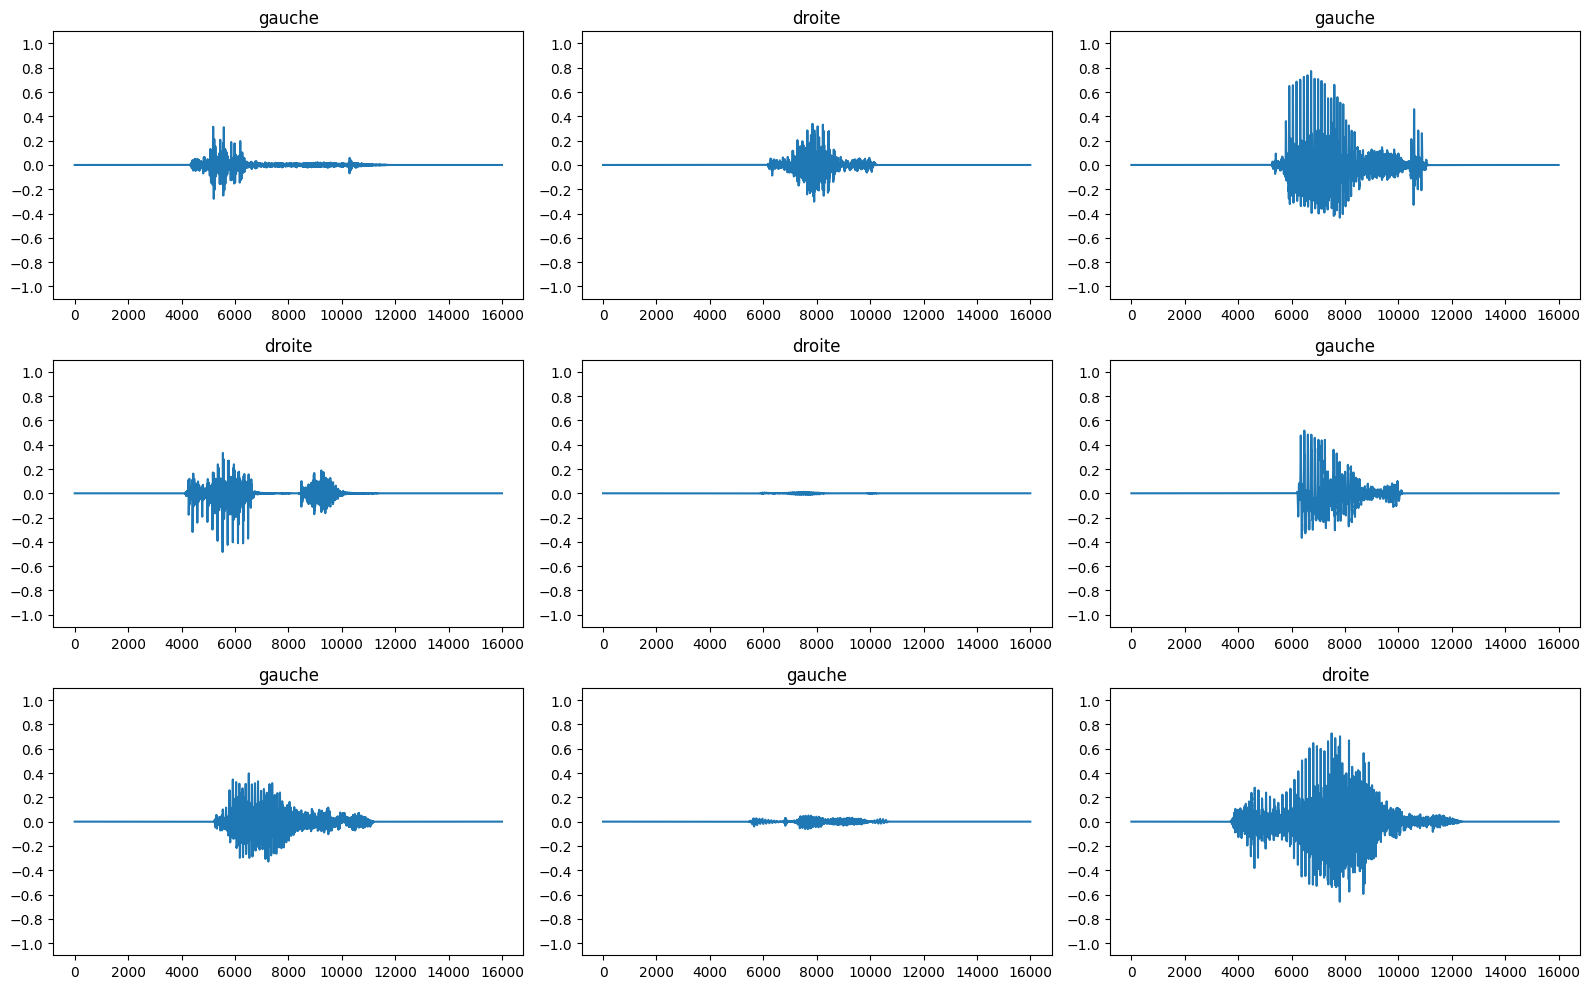

In [155]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

plt.tight_layout()

In [156]:

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))



Label: gauche
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: droite
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: gauche
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


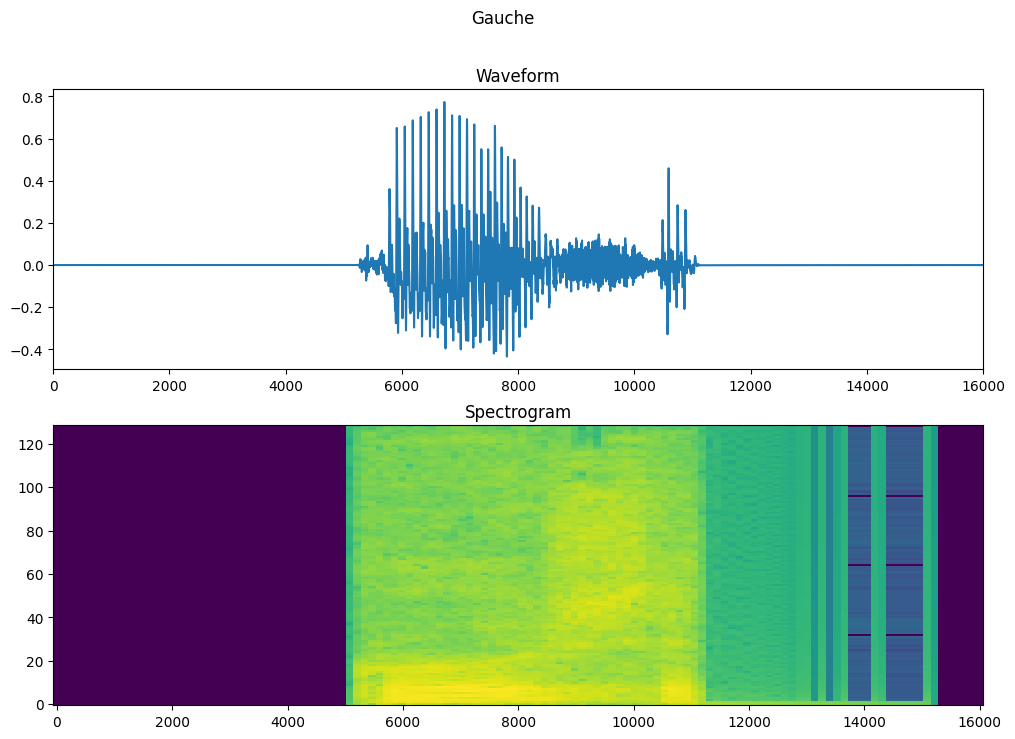

In [157]:

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, cmap=plt.cm.viridis)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()



In [158]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [159]:
train_spectrogram_ds = make_spec_ds(train_ds)
dev_spectrogram_ds = make_spec_ds(dev_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

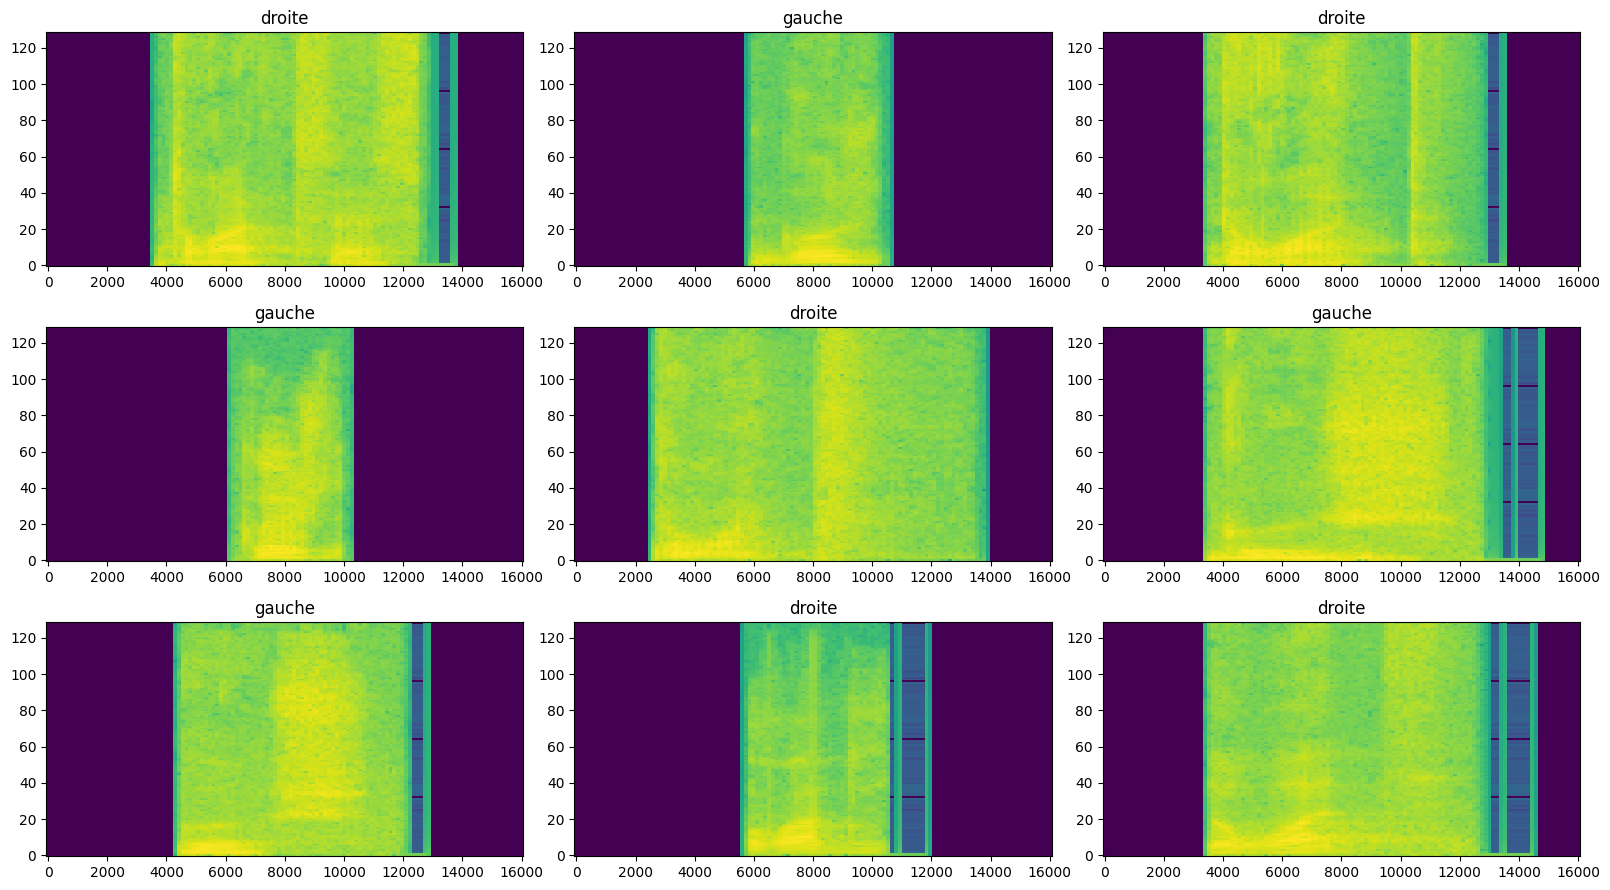

In [160]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()


In [161]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
dev_spectrogram_ds = dev_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [220]:
from tensorflow.keras import layers
from tensorflow.keras import models

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_13 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_13 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_26 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)     

In [311]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def f1_macro(y_true, y_pred):
    print(y_true.eval())
    num_classes = K.int_shape(y_true)[-1]
    f1_values = []

    for i in range(num_classes):
        class_true = y_true[:, i]
        class_pred = y_pred[:, i]
        f1_values.append(f1_score(class_true, class_pred))

    f1_macro = K.mean(tf.convert_to_tensor(f1_values))
    return f1_macro

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[f1_macro]
)


In [312]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=dev_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True),
)


Epoch 1/50


ValueError: in user code:

    File "/Users/prochet/miniconda3/envs/speech/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/89/s2d0csjj0r3gg89q3dnl4jfw0000gn/T/ipykernel_36644/3117541145.py", line 14, in f1_macro  *
        print(y_true.eval())

    ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`


KeyError: 'accuracy'

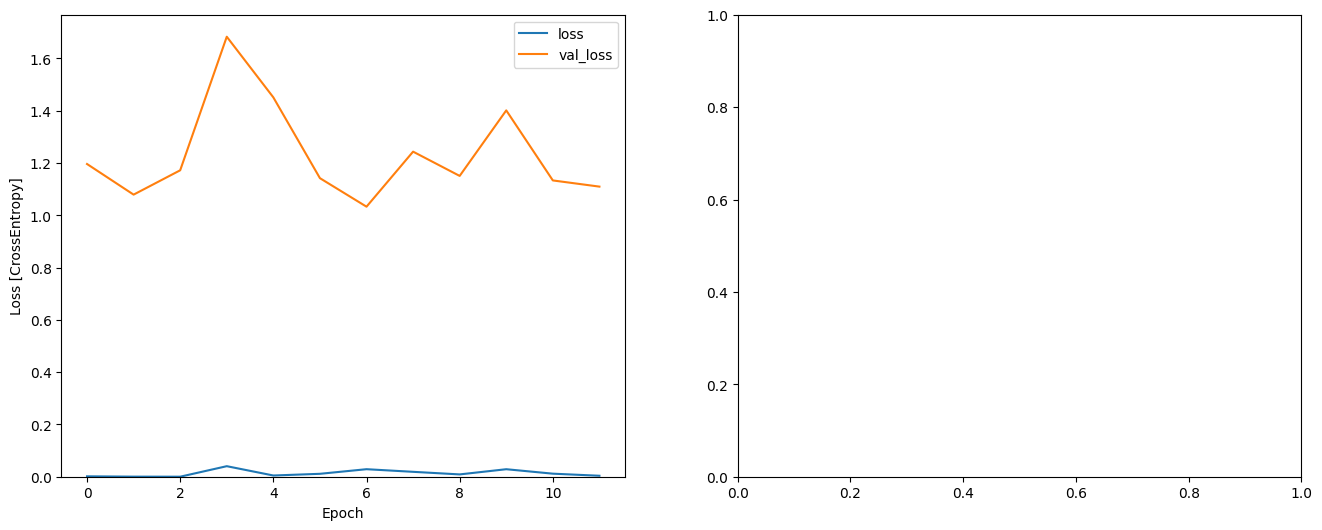

In [301]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [294]:
model.evaluate(test_spectrogram_ds, return_dict=True)


1/6 [====>.........................] - ETA: 0s - loss: 0.2486 - f1: 0.8889

6/6 [==============================] - 0s 6ms/step - loss: 0.2480 - f1: 0.9781


{'loss': 0.24799169600009918, 'f1': 0.9781139492988586}

In [306]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.93      0.99      0.96        81
           2       0.98      0.96      0.97        84
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         2
           5       1.00      0.33      0.50         3

    accuracy                           0.93       181
   macro avg       0.69      0.56      0.60       181
weighted avg       0.93      0.93      0.93       181



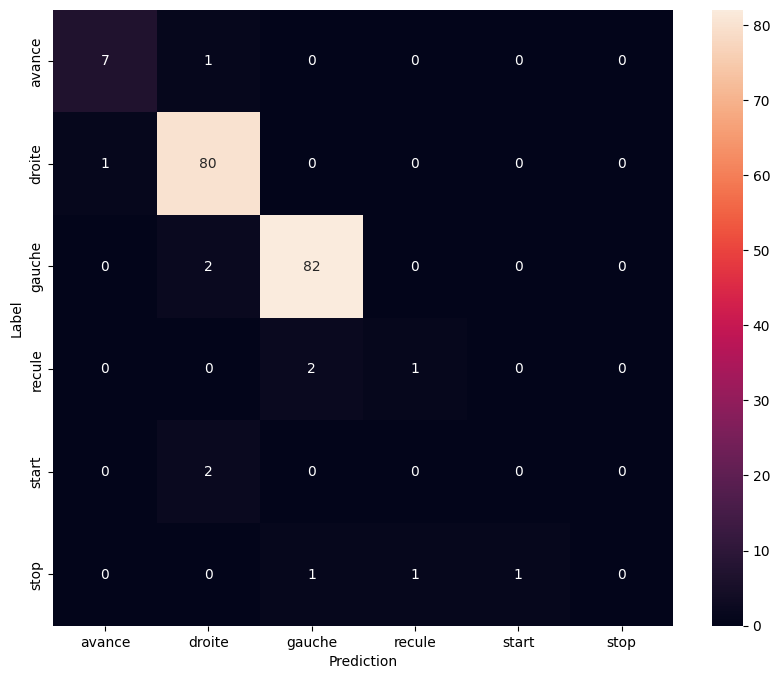

In [296]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
